- 微分したものに対して、changefinderを用いる

In [21]:
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
import datetime
import math
import copy

import changefinder

from visualize import visualization as my_VS
from select_datasets import Select_datasets as my_SD

plt.rcParams["font.family"] = "Yu Mincho"

## データゲット

### coolers

In [2]:
## cooler

place = "temp"
target_name = "CAMC_CT0"


path = f"/data7/2207_XRISM_PFT_TC7/db/{place}"
adr_pklfiles = glob.glob(path+"/**.pkl")

List_adr_adrfile = []
List_time_adrfile = []

for d_adrfile in adr_pklfiles:
    with open(d_adrfile, 'rb') as adrf:
        d = pickle.load(adrf)
        if len(List_time_adrfile) != 0:
            List_adr_adrfile = List_adr_adrfile+list(itertools.chain.from_iterable(np.array(d[[target_name]])))
            List_time_adrfile = List_time_adrfile+d.index.to_list()
        else:
            List_adr_adrfile = list(itertools.chain.from_iterable(np.array(d[[target_name]])))
            List_time_adrfile = d.index.to_list()

In [3]:
# DataFrame 格納
df_adrfile = pd.DataFrame({
    "time":List_time_adrfile,
    "adr":List_adr_adrfile
})

# 時間を並び替える
df_adrfile = df_adrfile.sort_values("time")
df_adrfile.index = range(len(df_adrfile))


### temp

In [6]:
## temp

place = "temp"
target_name = "CAMC_CT0"

path = f"/data7/2207_XRISM_PFT_TC7/db/{place}"
tem_pklfiles = glob.glob(path+"/**.pkl")

List_temp_tempfile = []
List_time_tempfile = []

for d_tempfile in tem_pklfiles:
    with open(d_tempfile, 'rb') as tempf:
        d = pickle.load(tempf)
        if len(List_temp_tempfile) != 0:
            List_temp_tempfile = List_temp_tempfile+list(itertools.chain.from_iterable(np.array(d[["CAMC_CT0"]])))
            List_time_tempfile = List_time_tempfile+d.index.to_list()
        else:
            List_temp_tempfile = list(itertools.chain.from_iterable(np.array(d[["CAMC_CT0"]])))
            List_time_tempfile = d.index.to_list()
            

KeyboardInterrupt: 

In [ ]:
# DataFrame 格納
df_tempfile = pd.DataFrame({
    "time":List_time_tempfile,
    "temp":List_temp_tempfile
})
# 時間を並び替える

df_tempfile = df_tempfile.sort_values("time")
df_tempfile.index = range(len(df_tempfile))

#　リストに格納
List_time_tempfile = np.array(df_tempfile["time"])
List_temp_tempfile = np.array(df_tempfile["temp"])

## 前処理

In [7]:
df_adrfile_pre = copy.copy(df_adrfile)
df_adrfile_pre["time"]=df_adrfile["time"].dt.round("s")#秒で足切り
df_adrfile_pre = df_adrfile_pre.groupby(["time"]).aggregate(np.mean)#重複する秒の平均を取る
df_adrfile_pre = df_adrfile_pre.iloc[1:,:] #7/4を除く
df_adrfile_pre = df_adrfile_pre.resample("S").mean()#欠損値のindexを補完
df_adrfile_pre = df_adrfile_pre.fillna(method='ffill')#欠損値のadrを前の値で補完

df_adrfile_pre["adr"] = df_adrfile_pre.adr.rolling(10).mean()
df_adrfile_pre= df_adrfile_pre.iloc[10:,:]

In [8]:
List_time_adrfile_pre = df_adrfile_pre.index.to_numpy()
List_adr_adrfile_pre = np.array(df_adrfile_pre["adr"])

## 微分

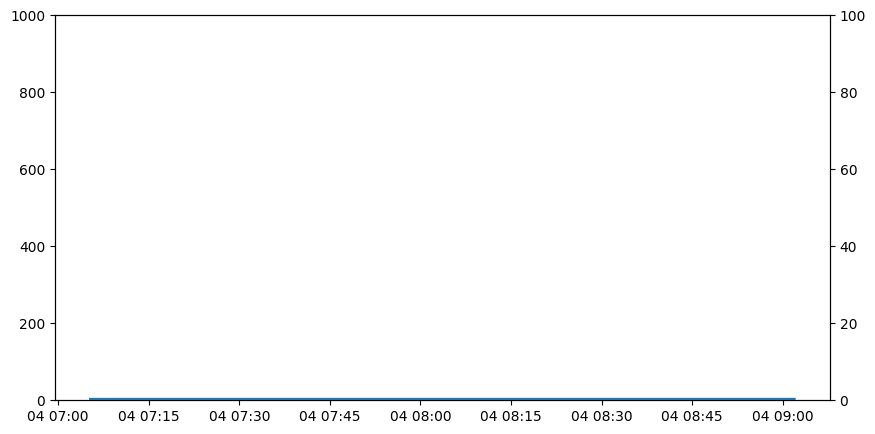

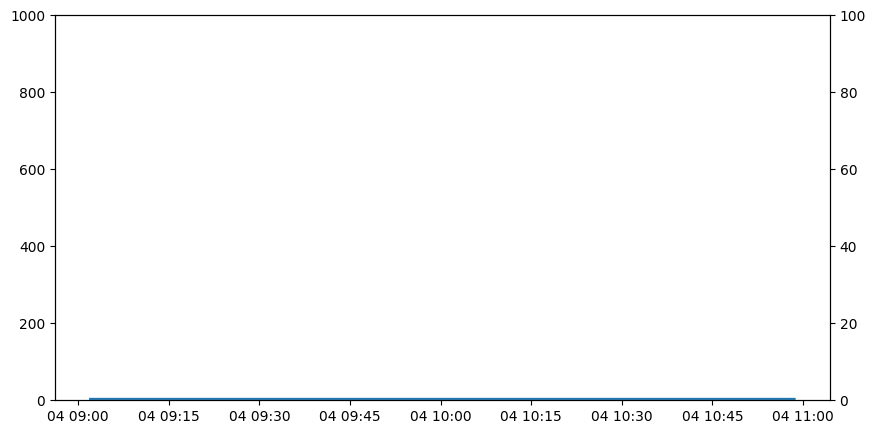

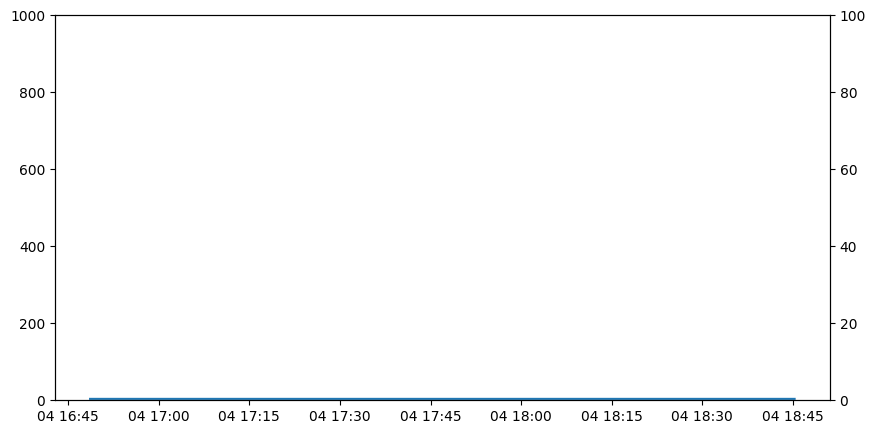

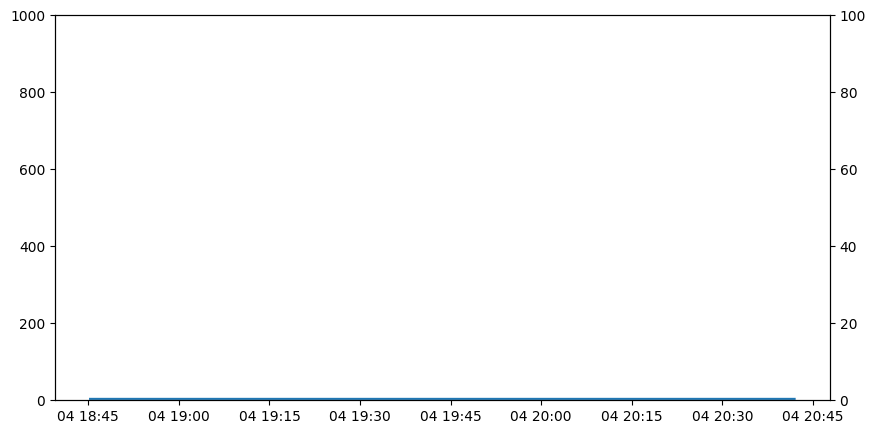

In [9]:
# 微分
List_adr_adrfile_pre_diff = np.diff(List_adr_adrfile_pre)

# 7000*610 に　reshape

yoko = 7000
tate = len(List_adr_adrfile_pre_diff)//yoko

List_adr_adrfile_pre_diff_reshape = List_adr_adrfile_pre_diff[:tate*yoko].reshape([tate,yoko])
List_adr_adrfile_pre_reshape = List_adr_adrfile_pre[:tate*yoko].reshape([tate,yoko])
List_time_adrfile_pre_reshape = List_time_adrfile_pre[:tate*yoko].reshape([tate,yoko])

# 7000ごとに行う

cf = changefinder.ChangeFinder(r=0.001,order=1,smooth=3)

for i in range(10):
    # change finde
    result_diff = np.empty(len(List_adr_adrfile_pre_diff_reshape[i]))

    for j,d in enumerate(List_adr_adrfile_pre_diff_reshape[i]):
        a = cf.update(d)
        result_diff[j] = cf.update(d)

    # plot
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    ax2 = ax.twinx()
    
    ax.plot(List_time_adrfile_pre_reshape[i],result_diff)
    ax2.plot(List_time_adrfile_pre_reshape[i],List_adr_adrfile_pre_reshape[i],color="red")
    ax2.set_ylim(0,100)
    ax.set_ylim(0,1000)

Text(0, 0.5, '温度 [mK]')

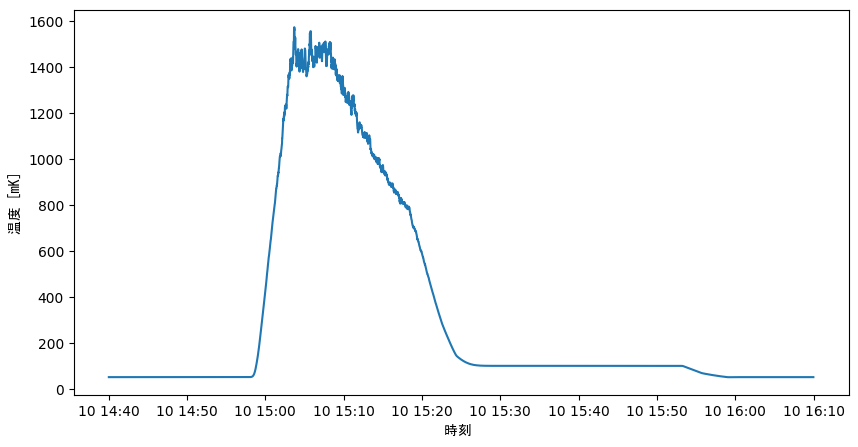

In [28]:
# time_start = List_time_adrfile_pre[1:][result_diff>200][0]
# time_stop = List_time_adrfile_pre[1:][result_diff>200][1]
time_start = np.datetime64('2022-02-10T14:40:00.000000000')
time_stop = np.datetime64('2022-02-10T16:10:00.000000000')

index_range = ((List_time_adrfile_pre > time_start) & (List_time_adrfile_pre < time_stop))

List_time_adrfile_short = List_time_adrfile_pre[index_range]
List_adr_adrfile_short = List_adr_adrfile_pre[index_range]

result_diff=np.diff(List_adr_adrfile_short)

fig,ax = plt.subplots(1,1,figsize=(10,5))
plt.rcParams["font.family"] = "Yu Mincho"

ax.plot(List_time_adrfile_short,List_adr_adrfile_short)
#ax.plot(List_time_adrfile_short[1:],result_diff,color="red")
#ax2 = ax.twinx()
#ax2.set_xlim(min(List_time_adrfile_short),max(List_time_adrfile_short))
ax.set_xlabel("時刻 ",fontname="MS Gothic")
ax.set_ylabel("温度 [mK]",fontname="MS Gothic")

- 次の方針

- 多次元の微分したデータを使ってchange finderを行う
- 頑張ってあれをつくる？